Assumptions: 
* Can represent $m_i$ as a linear combination of (potentially shifted) $m_p, \cdots, m_q \in \mathcal{N}^*(i)$. 
* Need to have reconstructed data over all time points where we are going to predict.
* $\exists \tau \geq 0: x_i(t) \approx x_j(t - \tau)$

**Input**: A matrix $M$ containing the interpolated regions in the reconstructed screening data.

**Output**: Adjacency matrix $A$ such that Laplacian $L$ of $A$ is the minimizer of $tr\left ( M^\top L M \right )$.

**Procedure** (infer adjacency matrix):
1. While not converged and for each node $i$:
    1. Randomly sample k neighbours $\mathcal{N}_k(i)$.
    2. Find the closest approximation $\hat{m}_i$ to $m_i$ using Sub-procedure 1 and compute
    $\mathcal{L}_n(i) = \left \| m_i - \hat{m}_i \right \|_2^2$.
    3. If $\mathcal{L}_n(i) < \mathcal{L}_{n - 1}(i)$, update $A_n$ by connecting node $i$ to nodes $j \in
    \mathcal{N}_k(i)$.
2. Should have smooth (i.e. small updates) to $A$ in each iteration $\left | A_n - A_{n - 1} \right |_F^2 < \epsilon$.

- Compute Laplacian $L_n$ from $A_n$ and abort iterations if $\left | \mathcal{D}_n - \mathcal{D}_{n - 1} \right | < \epsilon$ for $\mathcal{D}_n = tr\left ( M^\top L_n M \right )$.

**Sub-procedure 1** (profile synthesis):
1. Find the optimally aligned neighoburhood $\mathcal{N}^*_k(i)$ by doing for each node $j \in \mathcal{N}_k(i)$:
    1. Solve $\min_\tau \left \| m_i(t) - m_j(t - \tau) \right \|_2^2$ by some method of cross-correlation $\tau^* = \arg \max_t (m_i \star m_j)(t)$ 
    2. Use the shift operator $S^{\tau} m_j = m_j(t - \tau) = m_j^*$ and assign $m_j^*$ to $\mathcal{N}^*_k(i)$.
2. Derive $\hat{m}_i = \sum_{j \in \mathcal{N}^*_k(i)} m_j \beta^*_j$ from $\beta^*  = \min_{\beta} \left \| \mathcal{P}_\Omega \left ( m_i - \sum_{j \in \mathcal{N}^*_k(i)} m_j \beta_j \right ) \right \|_2^2$. Here, $\mathcal{P}_\Omega(x)$ limits $x$ to the interpolation region of $m_i$.

**Note**:
* Ensure properties of Adjacency matrix $\mathcal{A} = \left \{ A \in \mathbb{R}^{N \times N} \mid A^\top = A, A_{i, j} \geq 0 \forall i,j,   \right \}$.
* The stregnth of correlation $\rho^* = \max_t (m_i \star m_j)(t)$ implies how *good/agreable* the neighbours are.

**Questions**:
* Will updating $A_n$ when using adapted neighbourhood $\mathcal{N}^*$ for $\mathcal{L}_n(i)$ really minimize $\left | \mathcal{D}_n - \mathcal{D}_{n - 1} \right |$? I.e. will algorithm converge to optimal result?
* Will have smoothness in neighbourhoods by $m_n^* = \arg \min_x \left \| m_n - x  \right \|_2^2 + \lambda (x^\top L x)$ if kill signal in Laplacian outside of neigh?
* Can prove convergence?
* If $i$ share some neighbour with $j$, maybe $i$ will benefit from other neighbours of $j$?
* In synth control $\beta$ should be convex combination because more stable (nice properties). Use $\beta$ as weights on graph?
* Convergece criteria is accumulated loss less than some value?

In [1]:
from scipy import signal
from sklearn.linear_model import Ridge

import numpy as np 
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def interpolation_region_mask(Y):
    
    O = np.zeros_like(Y)
    for i, y in enumerate(Y):
        
        t_start = np.argmax(Y[i] != 0)
        t_end = np.argmax(np.cumsum(Y[i])) + 1
        
        O[i, t_start:t_end] = 1
        
    return O

In [3]:
def lead_shift(C, seed=42):
    """Simulate leading profiles."""
    np.random.seed(seed)
    
    C_leading, taus = [], []
    for c in C:
        
        tau = int(np.random.random() * (len(c) / 3))
         
        c_shifted = np.zeros_like(c)
        c_shifted[tau:] = c[:int(len(c) - tau)]
        
        C_leading.append(c_shifted)
        taus.append(tau)
        
    return np.array(C_leading), np.array(taus)

In [4]:
def lag_shift(C, taus, seed=42):
    """Simulate lagging profiles."""
    
    np.random.seed(seed)

    C_lagged = []
    for c, tau in zip(C, taus):
                
        c_shifted = np.zeros_like(c)
        
        idx = np.argmax(c != 0) - tau
        c_shifted[idx:sum(c != 0) + idx] = c[c != 0]
        C_lagged.append(c_shifted)
        
    return np.array(C_lagged)

In [5]:
def align(C, taus):
    
    C_lagged = []
    for c, tau in zip(C, taus):
        
        c_shifted = np.zeros_like(c)
        
        p = np.argmax(c != 0)
    
        # Left shifted.
        if tau > 0:
            k = p - tau
    
        # Right shifted.
        elif tau < 0:
            k = abs(tau) + p
        
        # Not shifted.
        else:
            k = p
         
        # NOTE (edge case): For some cases will k < 0, which means optimal alignment uses only
        # a part of the shifted profile.
        if k < 0:
            sliced_c = c[c > 0][abs(k):]
            c_shifted[:len(sliced_c)] = sliced_c   

        else:
            c_shifted[k:sum(c > 0) + k] = c[c > 0]
        
        C_lagged.append(c_shifted)
        
    return np.array(C_lagged)

In [6]:
def profile_synthesis(i, Z, alpha=0):
    
    Z_neigh = []
    for j, z in enumerate(Z):
        
        if j == i:
            continue
        
        Z_neigh.append(z)
    
    t_start = np.argmax(Z[i] != 0)
    t_end = np.argmax(np.cumsum(Z[i]))
    Z_neigh = np.array(Z_neigh)#[np.arange(3), t_start:t_end]

    #beta = np.linalg.inv(Z_neigh.T @ Z_neigh) @ Z_neigh.T @ Z[i, t_start:t_end]
    
    # Beta should be convex combination.
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(np.transpose(Z_neigh), Z[i])#, t_start:t_end])
    beta = model.coef_
    
    z_hat = np.zeros(Z.shape[1])
    #z_hat[t_start:t_end] = np.transpose(Z_neigh) @ beta
    z_hat = np.transpose(Z_neigh) @ beta
    
    return z_hat

# Synthetic data

In [7]:
M = np.load("../data/M.npy")

np.random.seed(42)
samples = np.random.choice(range(M.shape[0]), size=4, replace=False)

Q = []
for m in M[samples]:
    
    # Simulate zero-padding.
    m_scaled = 3 * ((m - min(m)) / (max(m) - min(m)))
    m_scaled[m_scaled < 0.5] = 0

    Q.append(m_scaled)

Z = np.array(Q)
Z_shifted, gt_taus = lead_shift(Z)

## Profile alignment

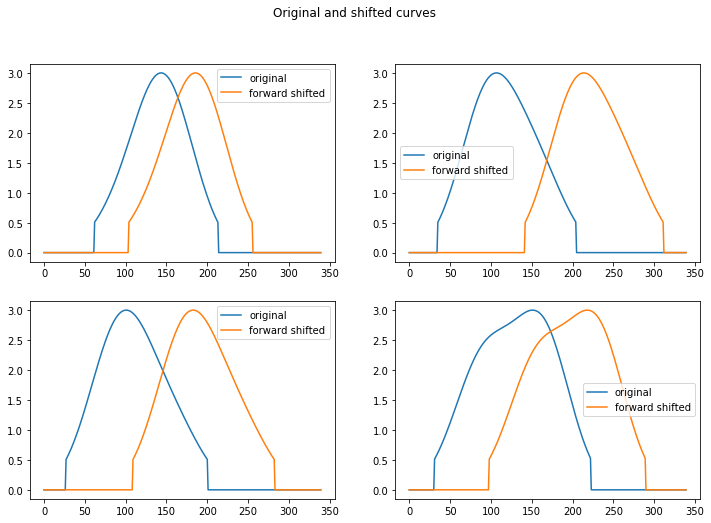

In [8]:
# Simple lead shift.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Original and shifted curves")
for i, axis in enumerate(axes.ravel()):
    
    shift = np.argmax(Z[i])
    
    axis.plot(Z[i], label="original")
    axis.plot(Z_shifted[i], label="forward shifted")
    axis.legend()

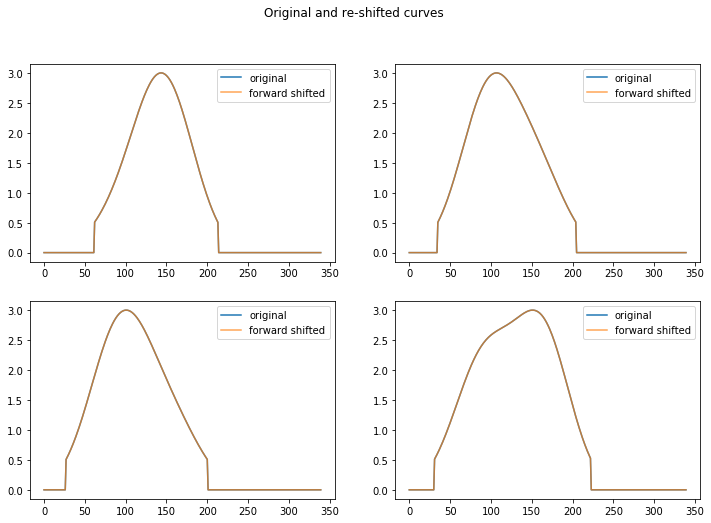

In [9]:
estimated_taus = [np.argmax(signal.correlate(z_shifted, z)) + 1 - len(z)
                  for z, z_shifted in zip(Z, Z_shifted)]

Z_back_shifted = align(Z_shifted.copy(), estimated_taus)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Original and re-shifted curves")
for i, axis in enumerate(axes.ravel()):
    
    shift = np.argmax(Z[i] != 0)
    
    tau_hat = estimated_taus[i]
    
    axis.plot(Z[i], label="original")
    axis.plot(Z_back_shifted[i], label="forward shifted", alpha=0.7)
    axis.legend()

## Profile synthesis

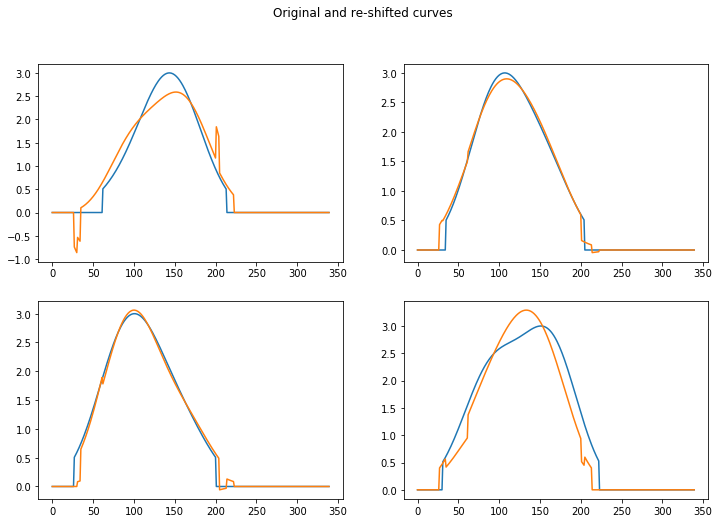

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle("Original and re-shifted curves")
for i, axis in enumerate(axes.ravel()):
    
    z_ref = Z[i].copy()        
    axis.plot(z_ref, label="Original")
    
    # Use the profiles in Z expect z_i in approximating z_i.
    z_ref_hat = profile_synthesis(i, Z, alpha=1)
    axis.plot(z_ref_hat, label="Synthezised")

# Screening data

In [11]:
M = np.load("/Users/sela/Desktop/recsys_paper/results/screening/mf/train/train_Xrec.npy")
Y = np.load("/Users/sela/Desktop/recsys_paper/data/screening/train/X_train.npy")
O = interpolation_region_mask(Y)

M = M * O

np.random.seed(42)
samples = np.random.choice(range(M.shape[0]), size=18, replace=False)
Q = M[samples]

## Profile alignment

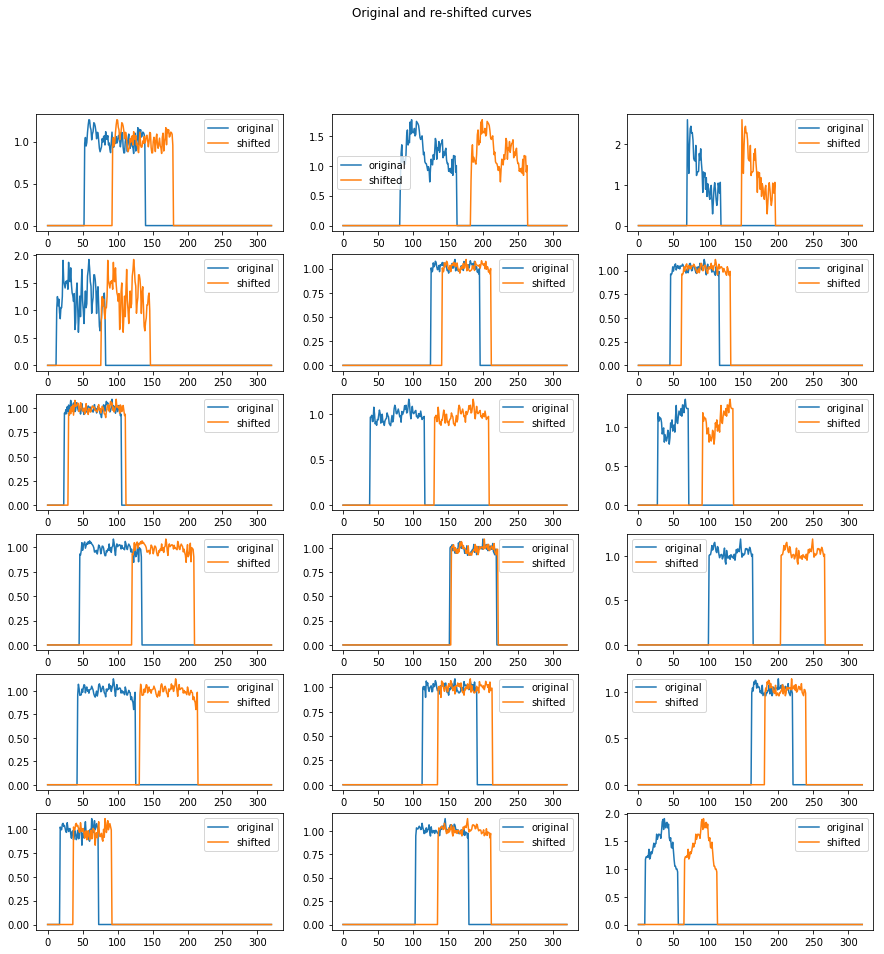

In [12]:
# Simple lead shift.
Q_shifted, gt_taus = lead_shift(Q)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
fig.suptitle("Original and re-shifted curves")
for i, axis in enumerate(axes.ravel()):
        
    axis.plot(Q[i], label="original")
    axis.plot(Q_shifted[i], label="shifted")
    axis.legend()

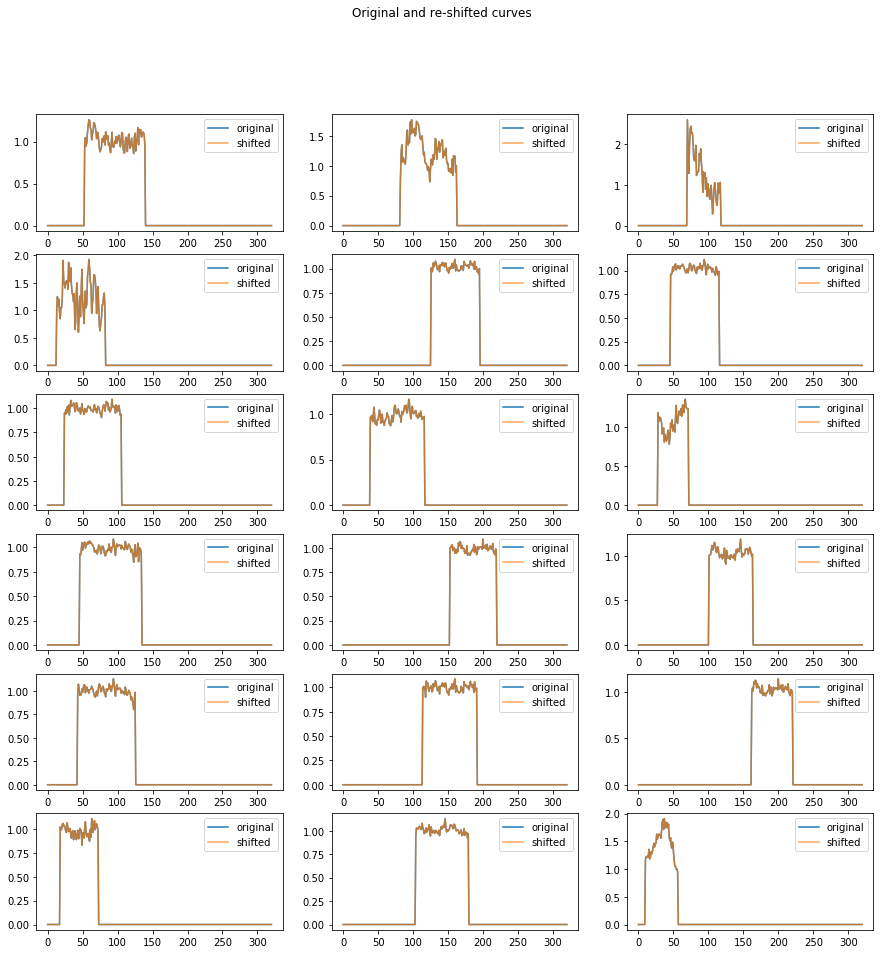

In [13]:
estimated_taus = [np.argmax(signal.correlate(q_shifted, q)) + 1 - len(q)
                  for q, q_shifted in zip(Q, Q_shifted)]

Q_back_shifted = align(Q_shifted.copy(), estimated_taus)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
fig.suptitle("Original and re-shifted curves")
for i, axis in enumerate(axes.ravel()):
    axis.plot(Q[i], label="original")
    axis.plot(Q_back_shifted[i], label="shifted", alpha=0.7)
    axis.legend()

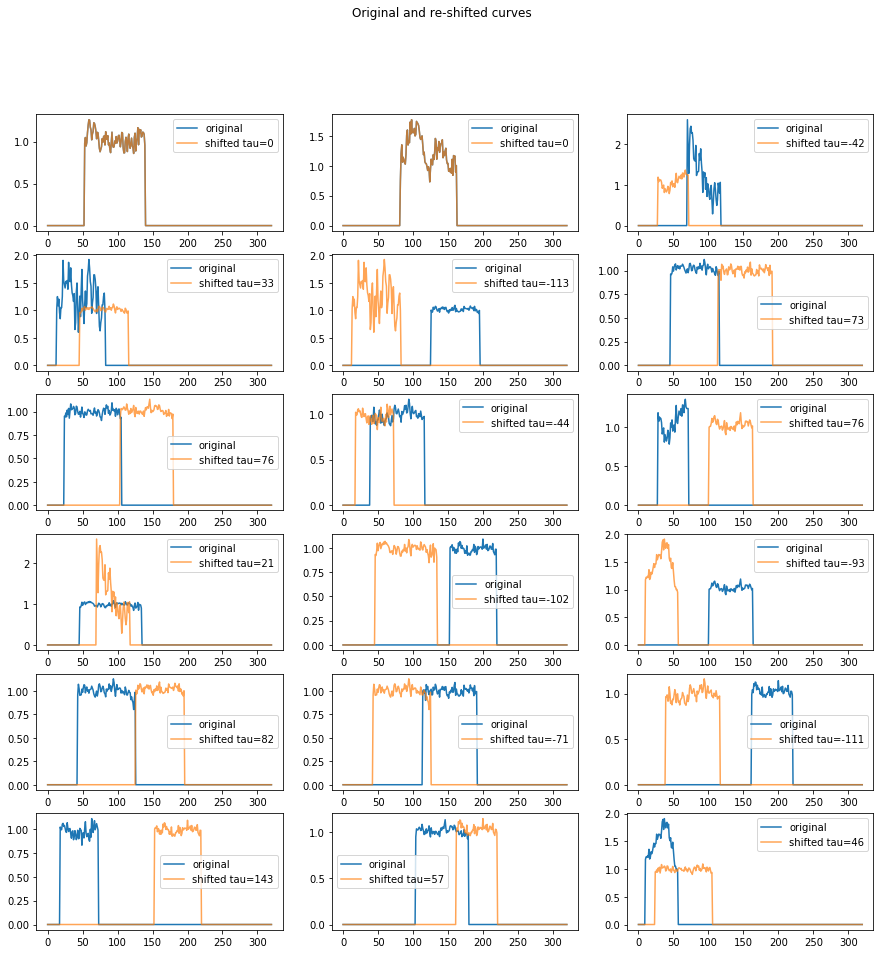

In [14]:
# Randomly select pairs of leading/lagging profiles.
Q_shuff = Q.copy()
np.random.seed(42)
np.random.shuffle(Q_shuff)

# NOTE: tau is not necessarily at start of original when using cross-correlation.
# Contrary to convolution looking for best overlap, cross-correlation looks for 
# best correlation.
estimated_taus = [np.argmax(signal.correlate(q_shifted, q)) + 1 - len(q)
                  for q, q_shifted in zip(Q, Q_shuff)]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
fig.suptitle("Original and re-shifted curves")
for i, axis in enumerate(axes.ravel()):

    axis.plot(Q[i], label="original")
    axis.plot(Q_shuff[i], label=f"shifted tau={estimated_taus[i]}", alpha=0.7)
    axis.legend()

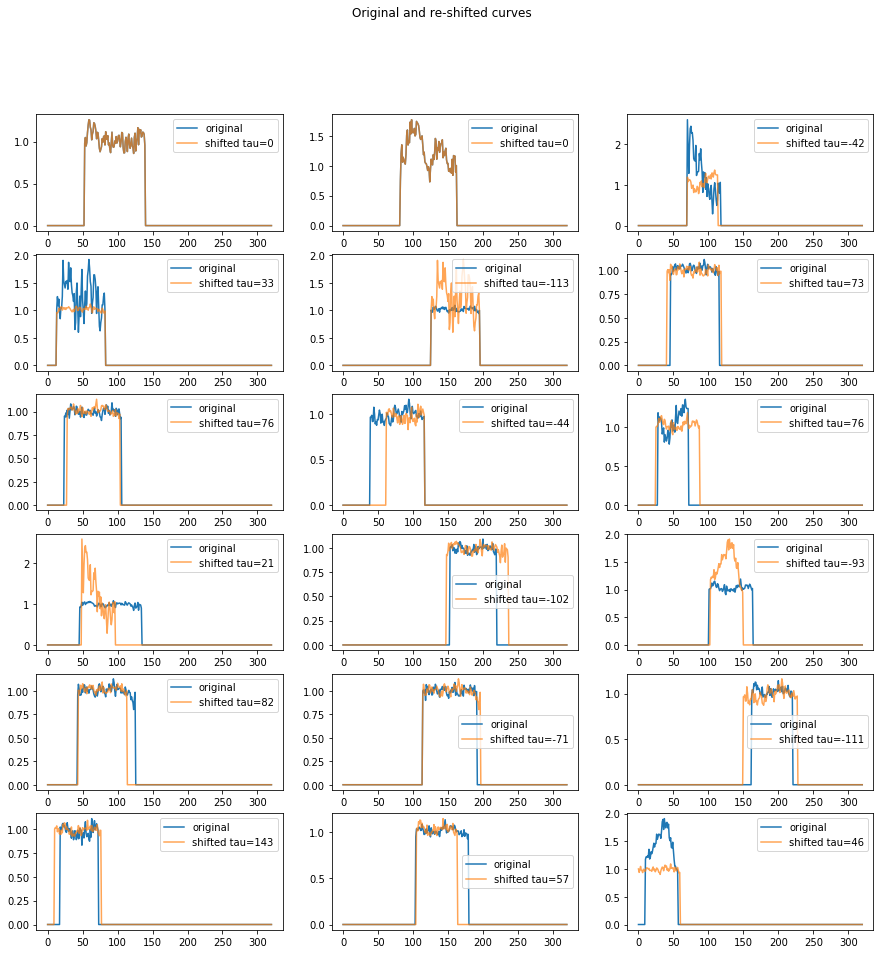

In [15]:
# The optimal alignment of two random profiles.
Q_shuff = Q.copy()
np.random.seed(42)
np.random.shuffle(Q_shuff)

# NOTE: Using cross-correlation.
estimated_taus = [np.argmax(signal.correlate(q_shifted, q)) + 1 - len(q)
                  for q, q_shifted in zip(Q, Q_shuff)]        
        
Q_back_shifted = align(Q_shuff, estimated_taus)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
fig.suptitle("Original and re-shifted curves")
for i, axis in enumerate(axes.ravel()):
    
    axis.plot(Q[i], label="original")
    axis.plot(Q_back_shifted[i], label=f"shifted tau={estimated_taus[i]}", alpha=0.7)
    axis.legend()

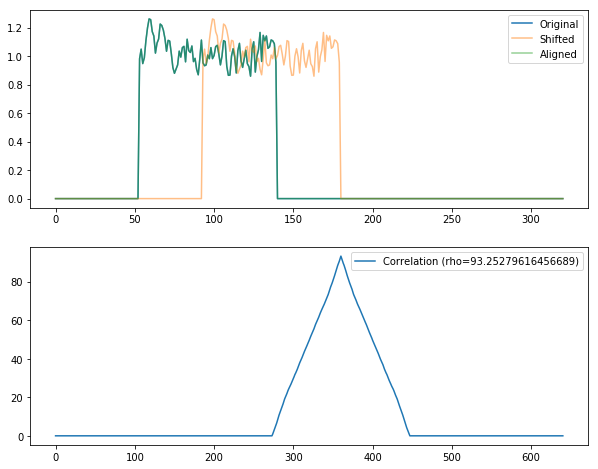

In [16]:
# Measure correlation.
q = Q[0]
q_shifted = Q_shifted[0]

C = signal.correlate(q_shifted, q) 
estimated_tau = np.argmax(C) + 1 - len(q)
correlation = max(C) + 1 - len(q)
c_shifted = np.zeros_like(q_shifted)

p = np.argmax(q_shifted != 0)
if estimated_tau > 0:
    k = p - estimated_tau
elif estimated_tau < 0:
    k = abs(estimated_tau) + p
else:
    k = p

if k < 0:
    sliced_c = q_shifted[q_shifted > 0][abs(k):]
    c_shifted[:len(sliced_c)] = sliced_c   
else:
    c_shifted[k:sum(q_shifted > 0) + k] = q_shifted[q_shifted > 0]

q_back_shifted = np.array(c_shifted)

fig, axes = plt.subplots(nrows=2, figsize=(10, 8))
axes[0].plot(q, label="Original")
axes[0].plot(q_shifted, label=f"Shifted", alpha=0.5)
axes[0].plot(q_back_shifted, label="Aligned", alpha=0.5)
axes[0].legend()
axes[1].plot(C, label=f"Correlation (rho={max(C)})")
axes[1].legend()

## Profile synthesis

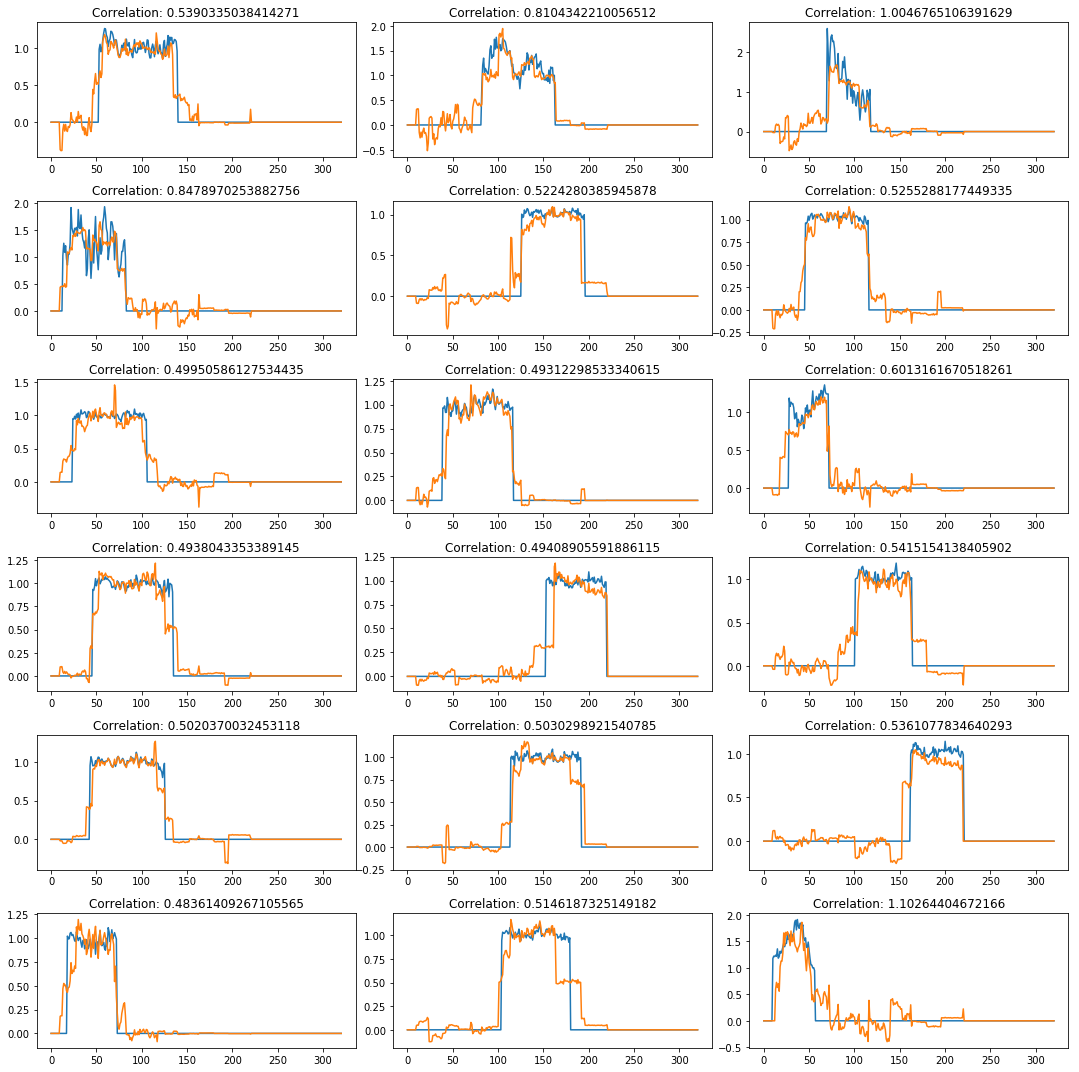

In [17]:
# NOTE: Using cross-correlation.
estimated_taus, correlation = [], []
for q, q_shifted in zip(Q, Q_shifted):
    
    C = signal.correlate(q_shifted, q) 
    estimated_taus.append(np.argmax(C) + 1 - len(q))
    correlation.append(max(C) / sum(C != 0))
    
Q_back_shifted = align(Q_shifted, estimated_taus)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axis in enumerate(axes.ravel()):
    
    q_ref = Q[i].copy()        
    axis.plot(q_ref, label="Original")
    
    q_ref_hat = profile_synthesis(i, Q_back_shifted, alpha=1)
    axis.plot(q_ref_hat, label="Synthezised")
    axis.set_title(f"Correlation: {correlation[i]}")
plt.tight_layout()

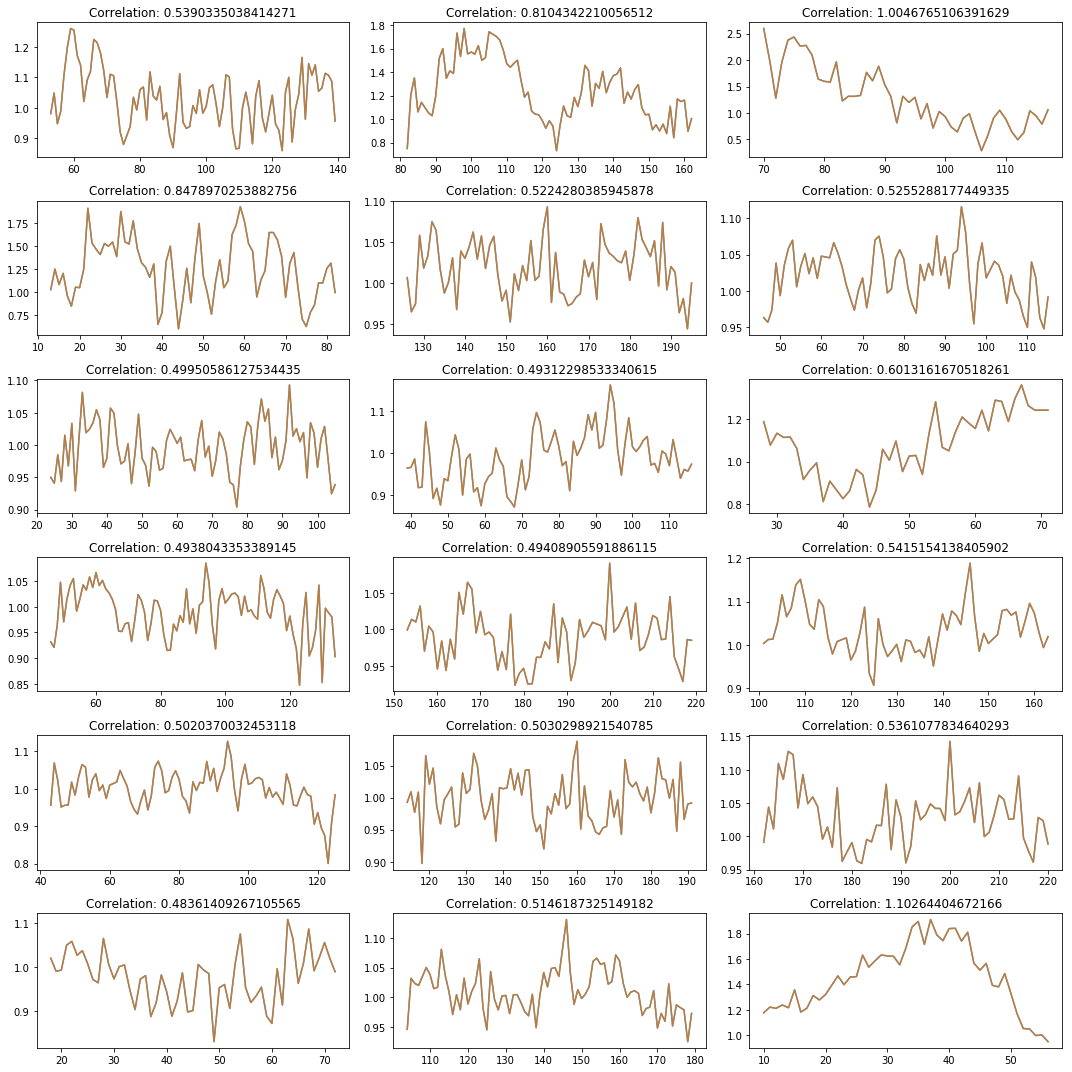

In [18]:
# A closer look

# NOTE: Using cross-correlation.
estimated_taus, correlation = [], []
for q, q_shifted in zip(Q, Q_shifted):
    
    C = signal.correlate(q_shifted, q) 
    estimated_taus.append(np.argmax(C) + 1 - len(q))
    correlation.append(max(C) / sum(C != 0))         
        
Q_back_shifted = align(Q_shifted, estimated_taus)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axis in enumerate(axes.ravel()):
    
    q = Q[i]    
    q_nan = np.ones_like(q) * np.nan
    q_nan[q != 0] = q[q != 0]
    
    q_shifted = Q_back_shifted[i]
    q_shifted_nan = np.ones_like(q_shifted) * np.nan
    q_shifted_nan[q_shifted != 0] = q_shifted[q_shifted != 0]
    
    axis.plot(q_nan, label="original")
    axis.plot(q_shifted_nan, label=f"shifted tau={estimated_taus[i]}", alpha=0.7)
    axis.set_title(f"Correlation: {correlation[i]}")
plt.tight_layout()

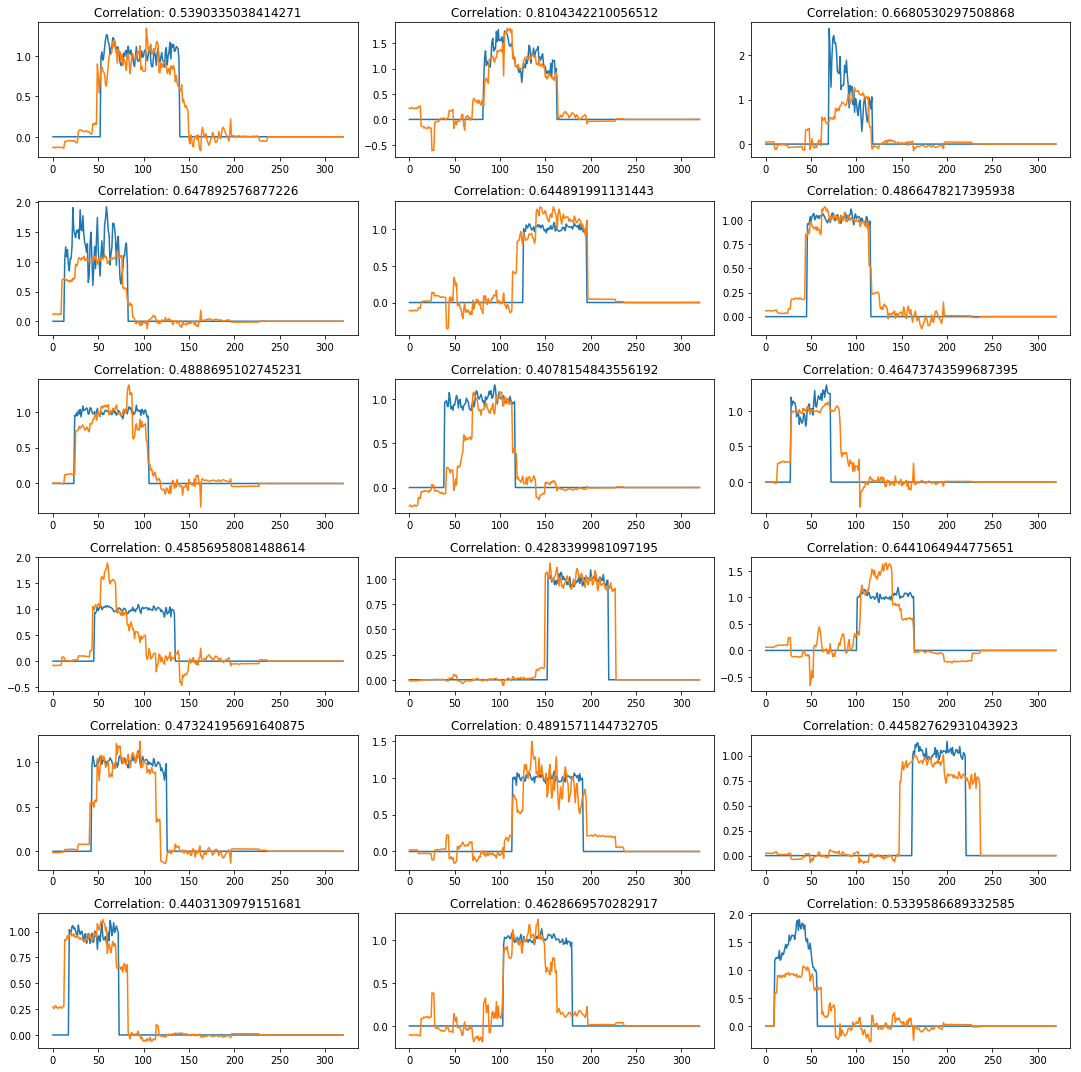

In [19]:
# Try with some shifted (shuffled) rec screening data form CMF model.
Q_shuff = Q.copy()
np.random.seed(42)
np.random.shuffle(Q_shuff)

# NOTE: Using cross-correlation.
estimated_taus, correlation = [], []
for q, q_shifted in zip(Q, Q_shuff):
    
    C = signal.correlate(q_shifted, q) 
    estimated_taus.append(np.argmax(C) + 1 - len(q))
    correlation.append(max(C) / sum(C != 0))       
        
Q_back_shifted = align(Q_shuff, estimated_taus)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axis in enumerate(axes.ravel()):
    
    q_ref = Q[i].copy()        
    axis.plot(q_ref, label="Original")
    
    q_ref_hat = profile_synthesis(i, Q_back_shifted, alpha=1)
    axis.plot(q_ref_hat, label="Synthezised")
    axis.set_title(f"Correlation: {correlation[i]}")
plt.tight_layout()

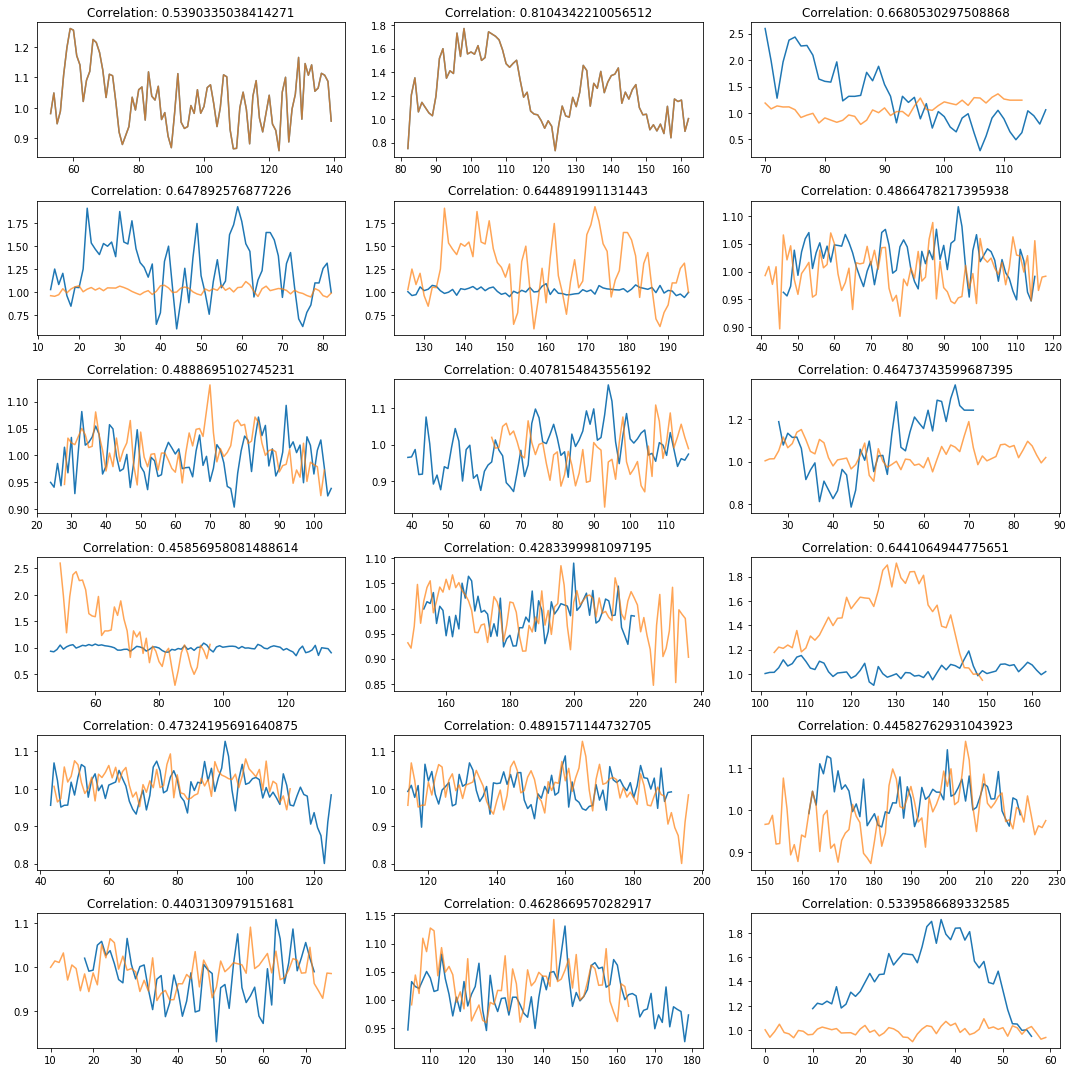

In [20]:
# A closer look

# Try with some shifted (shuffled) rec screening data form CMF model.
Q_shuff = Q.copy()
np.random.seed(42)
np.random.shuffle(Q_shuff)

# NOTE: Using cross-correlation.
estimated_taus, correlation = [], []
for q, q_shifted in zip(Q, Q_shuff):
    
    C = signal.correlate(q_shifted, q) 
    estimated_taus.append(np.argmax(C) + 1 - len(q))
    correlation.append(max(C) / sum(C != 0))          
        
Q_back_shifted = align(Q_shuff, estimated_taus)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
for i, axis in enumerate(axes.ravel()):
    
    q = Q[i]    
    q_nan = np.ones_like(q) * np.nan
    q_nan[q != 0] = q[q != 0]
    
    q_shifted = Q_back_shifted[i]
    q_shifted_nan = np.ones_like(q_shifted) * np.nan
    q_shifted_nan[q_shifted != 0] = q_shifted[q_shifted != 0]
    
    axis.plot(q_nan, label="original")
    axis.plot(q_shifted_nan, label=f"shifted tau={estimated_taus[i]}", alpha=0.7)
    axis.set_title(f"Correlation: {correlation[i]}")
plt.tight_layout()

# Algorithm

In [ ]:
lmbda = 1

# The projected data which is smooth over the assumed graph.
M_star_smooth = np.asarray(np.matmul(np.linalg.inv(np.eye(L.shape[0]) + lmbda * L), M_star))
print(np.trace(M_star_smooth.T @ L @ M_star_smooth))
print(np.linalg.norm(M_star_smooth.T @ L @ M_star_smooth))

In [ ]:
# * https://numpy.org/doc/stable/reference/generated/numpy.correlate.html
# * https://en.wikipedia.org/wiki/Granger_causality
# * https://lexfridman.com/fast-cross-correlation-and-time-series-synchronization-in-python/
# * https://en.wikipedia.org/wiki/Lag_operator
# Optimize using tensorflow and Numba.
# Repeat until convergence.
# * norm(A - A_prev) > tol
# * Can also compare trace(X.T @ A @ X) over iterations.
# * Monitor loss aggregated over all nodes.
def infer_adjacency():
    
    # Initialize A as random (Erdős) graph.
    
    while not converged:

        A_prev = A.copy()

        # Find a k-neighbour approximation to each node signal.
        for i, m_i in enumerate(M):

            # Randomly sample n neighbour candidates.
            N = sample_neighbours(i, A, size=k, seed=seed)

            # Find the closes approximation to m_i using these neighbours.
            N_star, beta_star = approximate_signal(M[N, :], m_i)
            
            # Update the network connections to the new neighbourhood of 
            # m_i if loss improves.
            loss_i = np.linalg.norm(m_i - N_star @ beta_star) ** 2
            if loss_i < loss_i_prev:
                
                A = update_connections(A, N_star)
                

def sample_neighbours(i, A, size, seed):
    
    # Make sure i is not part of the neighbourhood.
    candidates = list(set(np.arange(A.shape[0])) - set(i))
    
    np.random.seed(seed)
    
    return np.random.choice(candidates, size=size)

In [ ]:
def approximate_signal(m_i, N):
    
    # For all n neighbours m_j, find their optimal alignment to m_i.
    # * Use a kernel that can be approximated with rff for speed-up.
    N_star = [optimal_alignment(m_i, m_j) for m_j in N]
    
    # Learn weights to tune the contribution from each (potentially shifted) profile.
    beta_star = solve_projected_ls(m_i, N_star)
    
    return N_star, beta_star


def optimal_alignment(m_i, m_j):
    # Finds the optimal aligment between m_i and m_j.
    
    # * Compare m_i to m_j using some kernel that we approximate with rff.
    
    return m_j_star


def solve_projected_ls():
    # Solves least squares using observations from only the 
    # interpolation region.
    
    
    
    return beta_star